# Python test: User movie rating prediction with the MovieLens 20M dataset
In this exercise we were presented with a dataset containing information about different movies (identified with a movieId), their genre, release date and descriptive tags. The datasets also contains information about different users of the IMDB website, where these users are identified  with an userId and they can rate different movies. Not every user has given every movie a rating, but we have access to the existing ones. We also have information of the relevance that the descriptive tags have on some movies and how users have described some of the movies. The main objective is to predict whether a user will give a movie a high rating (>= 4) or low rating (< 4). We were given freedom to use the model and variables of our preference.

## 1. First look into the data and initial setup

Libraries to use in this mini-project, the first ones are pretty standard, the other one are more specific to tasks we are doing; supervised learning and for the use of regular expressions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import re

We are now taking a first look into the data, because of time restraints, we are not doing a deeper EDA and we are just looking at the data type and headers. I am only loading all of them for demonstrative purposes

In [10]:
#First look into the movies dataset
movies_df = pd.read_csv('datasets/movie.csv')
display(movies_df.head())
movies_df.dtypes

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


movieId     int64
title      object
genres     object
dtype: object

This will be one of our more important datasets for the exercise, from here we can extract the movieId, title, genres and with some work, the year it was released.

In [11]:
#First look into the ratings dataset, we are dropping the column named timestamp because we have no use for it
ratings_df = pd.read_csv('datasets/rating.csv')
ratings_df = ratings_df.drop('timestamp',axis=1)
display(ratings_df.head())
ratings_df.dtypes

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


userId       int64
movieId      int64
rating     float64
dtype: object

This will be our other main dataset, we have the variable we are trying to predict with the column "rating". The dataframe contains the information of the rating that userId "X" gives to movie "Y". We can also join this dataset with the movie dataset thanks to the movieId field

In [17]:
#First look into genome_scores dataset. 
gs_df = pd.read_csv('datasets/genome_scores.csv')
display(gs_df.head())
gs_df.dtypes

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


movieId        int64
tagId          int64
relevance    float64
dtype: object

This dataset contains information about the relevance of each tag to describe the movieId, along with the tagId. The relevance field can be used as a descriptive variable for the models.

In [19]:
#First look into genome_tags dataset. 
gt_df = pd.read_csv('datasets/genome_tags.csv')
display(gt_df.head())
gt_df.dtypes

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


tagId     int64
tag      object
dtype: object

This dataset contains the names of the tagId, it might be useful to show the preferences a userId has. 

In [20]:
#First look into link dataset. 
link = pd.read_csv('datasets/link.csv')
display(link.head())
link.dtypes

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


movieId      int64
imdbId       int64
tmdbId     float64
dtype: object

At first glance, this dataset appears to have no relevant information for us.

In [21]:
#First look into tag dataset. 
tag = pd.read_csv('datasets/tag.csv')
display(tag.head())
tag.dtypes

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


userId        int64
movieId       int64
tag          object
timestamp    object
dtype: object

This document tells us which tags a user has given to a movie. At first glance we also won't be using it. So we are not bothering to remove the timestamp field.

## 2. General data preparation

We are going to expand the movies dataframe, so the year of release can be taken into consideration when building the model or creating some plots.

In [35]:
rex = '(\(\d+\))' #Regular expression used 
movies_year = movies_df.copy()
movies_year['year'] = movies_year['title'].str.extract(rex)                #Extract the digits in parenthesis
movies_year['year'] = movies_year['year'].str.strip('()')                  #Remove parenthesis from new column
#movies_year['year'].astype(str).astype(float)
movies_year['title'] = movies_year['title'].str.replace(rex,'',regex=True) #Remove the year in parenthesis from title column

movies_year.head()


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


We are going to prepare a dataframe that contains columns representing the different genres. It will contain a value of 1 if the movie belongs to the corresponding genre. We will use this base for a model where the predictive variables are the genres of the movie. One hot encoding was used 

In [36]:
movies_genre = movies_year.copy()
movies_genre['genres'] = movies_genre.genres.str.split('|') #Split the genre value into a list with the separator being | 

for index, row in movies_genre.iterrows():                  #Loop through each row in the dataframe, 
    for genre in row['genres']:                             #Loops through each genre in the genre column of the current row
        movies_genre.at[index, genre] = 1                   #Sets the value 1 at the intersection of the row and the current column iteration, this is where columns are created. 
        
movies_genre = movies_genre.fillna(0)                       
movies_genre = movies_genre.drop('genres',axis=1)

movies_genre.head()

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#We now have ready our two separate dataframes, one for ratings and one for movies and their characteristics
movies_genre.head()
ratings_df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [29]:
#We select the userId we want to do our prediction on, this also narrows down the calculation
desiredUserId = 1
userRating_df = ratings_df.loc[ratings_df['userId'] == desiredUserId]
userRating_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
...,...,...,...
170,1,8507,5.0
171,1,8636,4.5
172,1,8690,3.5
173,1,8961,4.0


In [32]:
#We want to work on one same dataframe with both rating and movie characteristics, so we will use a join expression with movieId
df = userRating_df.merge(movies_genre, on='movieId', how='inner')
#For personal formatting, I want the rating column to be the last one before the response variable 
df = df[[col for col in df.columns if col != 'rating'] + ['rating']]
#Now the dataframe is finished and we can start with the model
df

,userId,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed),rating
0,1,2,Jumanji,1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
1,1,29,"City of Lost Children, The (Cité des enfants p...",1995,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
2,1,32,Twelve Monkeys (a.k.a. 12 Monkeys),1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
3,1,47,Seven (a.k.a. Se7en),1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
4,1,50,"Usual Suspects, The",1995,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,8507,Freaks,1932,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
171,1,8636,Spider-Man 2,2004,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5
172,1,8690,Slaughterhouse-Five,1972,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.5
173,1,8961,"Incredibles, The",2004,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [163]:
#Linear regression model preparation

X = df.iloc[:, 4:-2] #Input features (genres)
y = df['rating']     #Target variable 


In [164]:
#Linear regression training phase using a train/test split of 80/20 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [165]:
#Evaluation of the Linear Model
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred) 
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}, R-squared: {r2:.2f}")

MSE: 0.10, R-squared: 0.04


In [166]:
#Rating prediction for all movies based on userId genre tendencies
movies_full_prediction = movies_genre.copy()
model_ratings = lr.predict(movies_genre.iloc[:, 3:-1])
print(model_ratings)

[3.58769339 3.68057736 3.9499279  ... 3.80495736 3.68820222 3.95030817]


In [167]:
#Preparing the final dataset, we are adding a column with the model rating and dropping the columns with the genres
movies_full_prediction['model_ratings'] = model_ratings.tolist()
movies_clean_ratings = movies_full_prediction.iloc[:,[1,2,-1]]
movies_clean_ratings.head()

,title,year,model_ratings
0,Toy Story,1995,3.587693
1,Jumanji,1995,3.680577
2,Grumpier Old Men,1995,3.949928
3,Waiting to Exhale,1995,4.050813
4,Father of the Bride Part II,1995,3.644250


In [168]:
#We now have our final dataframe, with the response variable being 0 when the rating is lower than 4 and 1 when it is 4 or higher
movies_final = movies_clean_ratings.copy()
movies_final['high_rating'] = movies_final['model_ratings'].apply( lambda x: 1 if x >= 4 else 0)
movies_final

,title,year,model_ratings,high_rating
0,Toy Story,1995,3.587693,0
1,Jumanji,1995,3.680577,0
2,Grumpier Old Men,1995,3.949928,0
3,Waiting to Exhale,1995,4.050813,1
4,Father of the Bride Part II,1995,3.644250,0
...,...,...,...,...
27273,Kein Bund für's Leben,2007,3.644250,0
27274,"Feuer, Eis & Dosenbier",2002,3.644250,0
27275,The Pirates,2014,3.804957,0
27276,Rentun Ruusu,2001,3.688202,0


In [169]:

print(f"userId {desiredUserId} would give an average rating of {movies_final['model_ratings'].mean():.2f} ± {movies_final['model_ratings'].std():.2f} and would only give a high rating to {movies_final['high_rating'].sum()} out of {movies_final['high_rating'].count()} ({(movies_final['high_rating'].sum()/movies_final['high_rating'].count())*100:.2f}%)")

userId 1 would give an average rating of 3.77 ± 0.16 and would only give a high rating to 3213 out of 27278 (11.78%)


In [170]:
movie_model_rating_query_id = int(input('Movie ID: \n' ))

print(f"The movie titled {movies_final.loc[(movie_model_rating_query_id-1),'title']}released in {movies_final.loc[(movie_model_rating_query_id-1),'year']} has a predicted rating of {movies_final.loc[(movie_model_rating_query_id-1),'model_ratings']:.2f} from userId {desiredUserId} ")                               


Movie ID: 
 1


The movie titled Toy Story released in 1995 has a predicted rating of 3.59 from userId 1 


In [171]:
#Now we go with some plots

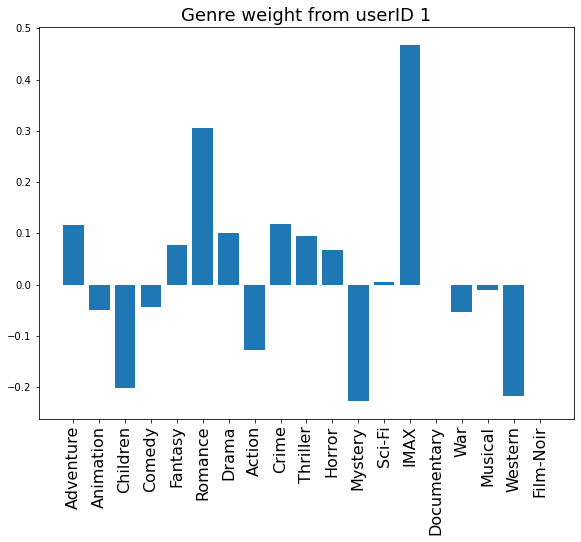

In [206]:
#Starting with the weight of every genre on the current user 
genre_list = np.array(df.columns[4:-2].values)
genre_coeff = lr.coef_

plt.figure(figsize=(9.6,7.2))
plt.bar(genre_list, genre_coeff)
plt.xticks(rotation = 90, size = 16)
plt.title('Genre weight from userID '+str(desiredUserId), size= 18)
plt.show()

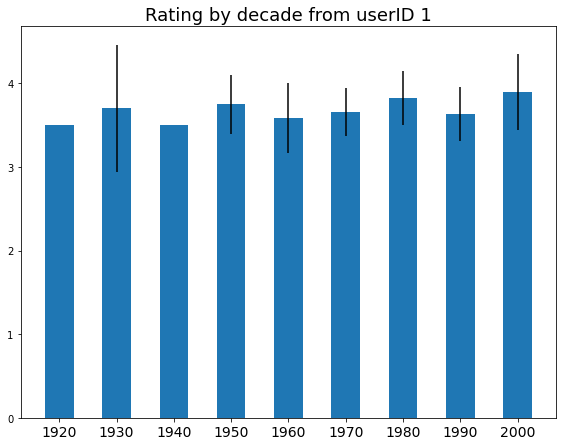

In [205]:
#Average predicted rating by decade
#pd.to_numeric(df['year'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
decade_avg_rating = df.groupby(df['year']//10*10)['rating'].agg(['mean','std'])


plt.figure(figsize=(9.6,7.2))
plt.bar(x = decade_avg_rating.index, height = decade_avg_rating['mean'], yerr = decade_avg_rating['std'],width=5)
plt.xticks(decade_avg_rating.index , size = 14)
plt.title('Rating by decade from userID '+str(desiredUserId), size= 18)
plt.show()